# NeuMF

This notebook demonstrates results of experiments with NeuMF model as well as how this model can be reused for one's goals

In [1]:
import sys

In [2]:
# Setup if code is running on colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/MyDrive/
    # ! rm -r LastFM/
    # ! git clone https://github.com/TimofeevAlex/LastFM.git
    sys.path.append('/content/gdrive/MyDrive/LastFM/src')
else:
    sys.path.append('src')

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [3]:
import os
import sys
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import model_to_dot

from IPython.display import clear_output

from train_test import train_test_split
from models import create_neumf_model, create_neumf_model_si, create_neumf_only_si
from neumf_helpers import create_train_step, create_test_step, create_inference, \
                        train_one_epoch, validate_one_epoch, test_one_epoch, plot_metrics
from metrics import compute_metrics
from preprocessing import build_get_negative_ratings
%load_ext autoreload
%autoreload 2

seed=0
np.random.seed(seed)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Loading the prepared dataset

All datasets can be found here: https://drive.google.com/drive/folders/14izEunqUyASA-fkS_EqrBcWMpHI1pXxQ?usp=sharing

It is impossible to merge datasets because of their sizes, thus we keep them separate

In [4]:
datafolder = 'lastfm-dataset-360K'
train = pd.read_csv(os.path.join(datafolder, 'train.csv'))
valid = pd.read_csv(os.path.join(datafolder, 'valid.csv'))
test = pd.read_csv(os.path.join(datafolder, 'test.csv'))
lastfm_360_behav = pd.read_csv(os.path.join(datafolder, 'behav-360k-processed.csv'))
lastfm_360_demo = pd.read_csv(os.path.join(datafolder, 'demo-360k-processed.csv'))
lastfm_360_demo = lastfm_360_demo.set_index('user_email').astype(bool)
test_users = np.load(os.path.join(datafolder, 'test_users.npy'))

In [5]:
artists = train['artist_id'].unique()
users = lastfm_360_demo.index.unique()

Set training parameters

In [6]:
num_artists = artists.max()
num_users = users.max()
num_user_features = lastfm_360_demo.shape[1] 
num_factors = 16
batch_size = 2 ** 16
k=10
threshold = 0.1

Prepare train,validation, and test loaders

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train)
train_dataset = train_dataset.batch(batch_size).shuffle(train.shape[0], seed=0, reshuffle_each_iteration=True)
valid_dataset = tf.data.Dataset.from_tensor_slices(valid)
valid_dataset = valid_dataset.batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test)
test_dataset = test_dataset.batch(batch_size)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=False, dpi=300)
plt.savefig('nlf_model_vertical.png')

<a id=content><a>
## Table of contents
1. ### [Basic experiments](#basic_exps)
    * [NeuMF without user features](#neumf_wo_si)
    * [NeuMF with user features](#neumf_w_si)
    * [NeuMF with only user features](#neumf_si)
2. ### [Different number of negative samples](#neg_samples)
    * [0.5 $\times$ positive samples](#0.5)
    * [2 $\times$ positive samples](#2)
    * [3 $\times$ positive samples](#3)
3. ### [Cold-start](#cold_start)
    * [NeuMF without user features](#cold_neumf_wo_si)
    * [NeuMF with user features](#cold_neumf_w_si)
    * [NeuMF with only user features](#cold_neumf_only_si)

<a id=basic_exps><a>
## Basic experiments 
[Back to content](#content)

<a id=neumf_wo_si><a>
### NeuMF without user features
[Back to content](#content)
    
This model doesn't exploit the user features branch

In [ ]:
# Define model, optimizer, and loss function
model = create_neumf_model(num_factors, num_artists, num_users, reg=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

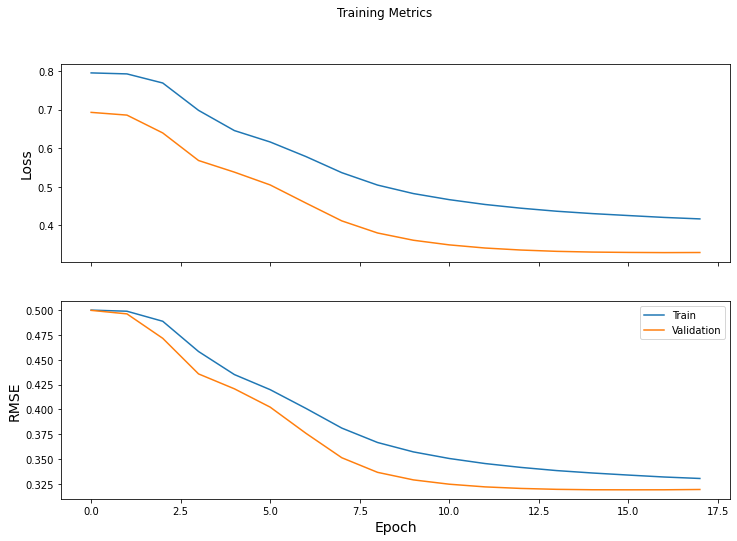

In [ ]:
num_epochs = 18
log_frequency = 1

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
val_loss_avg = tf.keras.metrics.Mean()
val_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

train_step = create_train_step(model, optimizer, loss_fn, epoch_loss_avg, epoch_rmse)
val_step = create_test_step(model, loss_fn, val_loss_avg, val_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

train_loss_results = []
train_rmse_results = []
val_loss_results = []
val_rmse_results = []

timenow = str(datetime.now())

try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)

for epoch in range(num_epochs):
    loss, rmse = train_one_epoch(train_step, train_dataset, lastfm_360_demo, epoch_loss_avg, epoch_rmse, threshold, si=False)
    train_loss_results.append(loss)
    train_rmse_results.append(rmse)

    if (epoch + 1) % log_frequency == 0:
        # Save model
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        loss, rmse = validate_one_epoch(val_step, valid_dataset, lastfm_360_demo, val_loss_avg, val_rmse, threshold, si=False)
        val_loss_results.append(loss)
        val_rmse_results.append(rmse)
        # Plot metrics 
        clear_output(wait=True)
        plot_metrics(train_loss_results, train_rmse_results, val_loss_results, val_rmse_results, epoch, \
                     log_frequency, timenow)


In [14]:
probs, loss, rmse = test_one_epoch(test_step, test_dataset, lastfm_360_demo, test_loss_avg, test_rmse, threshold, si=False)
print('Test loss:', loss)
print('Test RMSE:', rmse)

Test loss: 0.22964754
Test RMSE: 0.25797247


In [13]:
# Prepare a format of predicted ratings to compute metrics
pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
_, _, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)    

Metrics:

Precision @ 10: 0.283513527527864
Recall    @ 10: 0.5901456333837851
Ndcg @ 10: 0.6235488238295811
Hit rate: 2.75881635365322567
Arhr: 1.141353225948686



<a id=neumf_w_si><a>
### NeuMF with user features
[Back to content](#content)
    
This model uses both user branches

In [ ]:
# Define model, optimizer, and loss function
model = create_neumf_model_si(num_factors, num_user_features, num_artists, num_users, reg=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

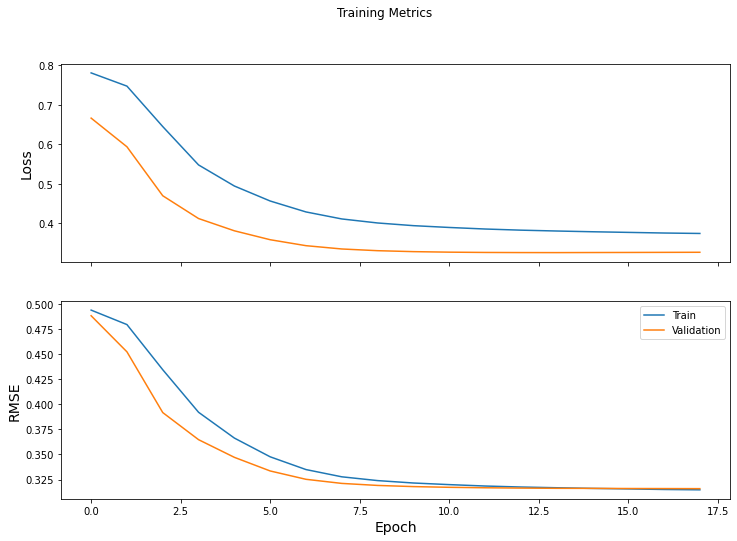

In [ ]:
num_epochs = 18
log_frequency = 1

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
val_loss_avg = tf.keras.metrics.Mean()
val_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

train_step = create_train_step(model, optimizer, loss_fn, epoch_loss_avg, epoch_rmse)
val_step = create_test_step(model, loss_fn, val_loss_avg, val_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

train_loss_results = []
train_rmse_results = []
val_loss_results = []
val_rmse_results = []

timenow = str(datetime.now())

try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)

for epoch in range(num_epochs):
    loss, rmse = train_one_epoch(train_step, train_dataset, lastfm_360_demo, epoch_loss_avg, epoch_rmse, threshold, si=True)
    train_loss_results.append(loss)
    train_rmse_results.append(rmse)

    if (epoch + 1) % log_frequency == 0:
        # Save model
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        loss, rmse = validate_one_epoch(val_step, valid_dataset, lastfm_360_demo, val_loss_avg, val_rmse, threshold, si=True)
        val_loss_results.append(loss)
        val_rmse_results.append(rmse)
        # Plot metrics 
        clear_output(wait=True)
        plot_metrics(train_loss_results, train_rmse_results, val_loss_results, val_rmse_results, epoch, log_frequency, timenow)


In [ ]:
probs, loss, rmse = test_one_epoch(test_step, test_dataset, lastfm_360_demo, test_loss_avg, test_rmse, threshold, si=True)
print('Test loss:', loss)
print('Test RMSE:', rmse)

Test loss: 0.20491828
Test RMSE: 0.2525181


In [ ]:
# Prepare a format of predicted ratings to compute metrics
pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
_, _, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)    

Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.292410627513718
Recall    @ 10: 0.5936949266836906
Ndcg @ 10: 0.6396757917292821
Hit rate: 2.9080932374444926
Arhr: 1.160976251112627


<a id=neumf_si><a>
### NeuMF with only user features
[Back to content](#content)
    
The model is without user IDs branch and with user features one

In [8]:
# Define model, optimizer, and loss function
model = create_neumf_only_si(num_factors, num_user_features, num_artists, num_users, reg=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

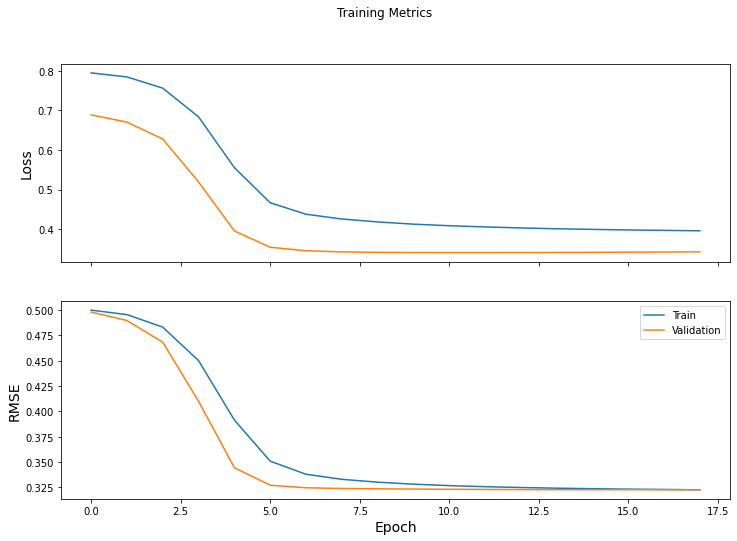

In [9]:
num_epochs = 18
log_frequency = 1

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
val_loss_avg = tf.keras.metrics.Mean()
val_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

train_step = create_train_step(model, optimizer, loss_fn, epoch_loss_avg, epoch_rmse)
val_step = create_test_step(model, loss_fn, val_loss_avg, val_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

train_loss_results = []
train_rmse_results = []
val_loss_results = []
val_rmse_results = []

timenow = str(datetime.now())

try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)

for epoch in range(num_epochs):
    loss, rmse = train_one_epoch(train_step, train_dataset, lastfm_360_demo, \
                                 epoch_loss_avg, epoch_rmse, threshold, si=False, only_si=True)
    train_loss_results.append(loss)
    train_rmse_results.append(rmse)

    if (epoch + 1) % log_frequency == 0:
        # Save model
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        loss, rmse = validate_one_epoch(val_step, valid_dataset, lastfm_360_demo, \
                                        val_loss_avg, val_rmse, threshold, si=False, only_si=True)
        val_loss_results.append(loss)
        val_rmse_results.append(rmse)
        # Plot metrics 
        clear_output(wait=True)
        plot_metrics(train_loss_results, train_rmse_results, val_loss_results, val_rmse_results, epoch, log_frequency, timenow)


In [10]:
probs, loss, rmse = test_one_epoch(test_step, test_dataset, lastfm_360_demo, \
                                   test_loss_avg, test_rmse, threshold, si=False, only_si=True)
print('Test loss:', loss)
print('Test RMSE:', rmse)

Test loss: 0.21494077
Test RMSE: 0.2516983


In [11]:
# Prepare a format of predicted ratings to compute metrics
pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
_, _, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)    

Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.2915210143085687
Recall    @ 10: 0.591940269356242
Ndcg @ 10: 0.6383488663742679
Hit rate: 2.899271862805197
Arhr: 1.1532471237974375


<a id=neg_samples><a>
# Different number of negative samples
[Back to content](#content)

<a id=0.5><a>
### NeuMF with user features, negative samples = 0.5 $\times$ positive samples  for each user
[Back to content](#content)
    
Preparing the dataset with a half of negative samples

In [ ]:
negative_train = train[train['rating'] == 0]
negative_train = negative_train.sample(negative_train.shape[0] // 2)
train_half = train.drop(negative_train.index)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_half)
train_dataset = train_dataset.batch(batch_size).shuffle(train_half.shape[0], seed=0, reshuffle_each_iteration=True)

In [ ]:
# Define model, optimizer, and loss function
model = create_neumf_model_si(num_factors, num_user_features, num_artists, num_users, reg=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

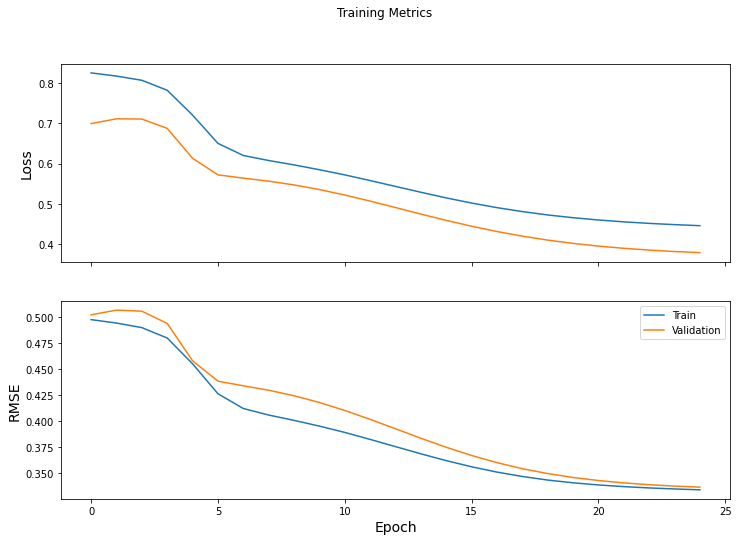

In [ ]:
num_epochs = 25
log_frequency = 1

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
val_loss_avg = tf.keras.metrics.Mean()
val_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

train_step = create_train_step(model, optimizer, loss_fn, epoch_loss_avg, epoch_rmse)
val_step = create_test_step(model, loss_fn, val_loss_avg, val_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

train_loss_results = []
train_rmse_results = []
val_loss_results = []
val_rmse_results = []

timenow = str(datetime.now())

try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)

for epoch in range(num_epochs):
    loss, rmse = train_one_epoch(train_step, train_dataset, lastfm_360_demo, epoch_loss_avg, epoch_rmse, threshold, si=True)
    train_loss_results.append(loss)
    train_rmse_results.append(rmse)

    if (epoch + 1) % log_frequency == 0:
        # Save model
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        loss, rmse = validate_one_epoch(val_step, valid_dataset, lastfm_360_demo, val_loss_avg, val_rmse, threshold, si=True)
        val_loss_results.append(loss)
        val_rmse_results.append(rmse)
        # Plot metrics 
        clear_output(wait=True)
        plot_metrics(train_loss_results, train_rmse_results, val_loss_results, val_rmse_results, epoch, log_frequency, timenow)


In [ ]:
probs, loss, rmse = test_one_epoch(test_step, test_dataset, lastfm_360_demo, test_loss_avg, test_rmse, threshold, si=True)
print('Test loss:', loss)
print('Test RMSE:', rmse)

Test loss: 0.3540876
Test RMSE: 0.32059693


In [ ]:
# Prepare a format of predicted ratings to compute metrics
pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
_, _, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)    

Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.2827041251140051
Recall    @ 10: 0.574244653750096
Ndcg @ 10: 0.6171206717727826
Hit rate: 2.8118505449815347
Arhr: 1.0733826293201343


<a id=2><a>
### NeuMF with user features, negative samples = 2 $\times$ positive samples   for each user
[Back to content](#content)
    
Loading the dataset with twice more negative samples. The dataset can be downloaded here https://drive.google.com/drive/folders/14izEunqUyASA-fkS_EqrBcWMpHI1pXxQ?usp=sharing

In [ ]:
train_twice = pd.read_csv(os.path.join(datafolder, 'train_twice.csv'))

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_twice)
train_dataset = train_dataset.batch(batch_size).shuffle(train_twice.shape[0], seed=0, reshuffle_each_iteration=True)

In [ ]:
# Define model, optimizer, and loss function
model = create_neumf_model_si(num_factors, num_user_features, num_artists, num_users, reg=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

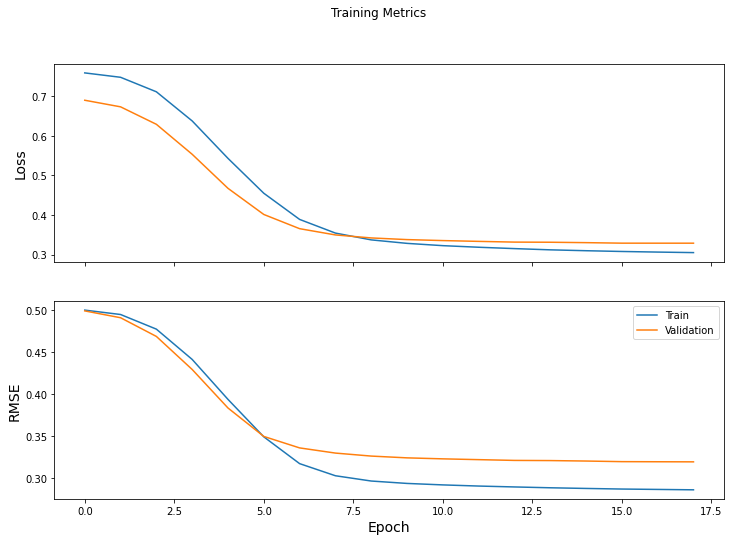

In [ ]:
num_epochs = 18
log_frequency = 1

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
val_loss_avg = tf.keras.metrics.Mean()
val_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

train_step = create_train_step(model, optimizer, loss_fn, epoch_loss_avg, epoch_rmse)
val_step = create_test_step(model, loss_fn, val_loss_avg, val_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

train_loss_results = []
train_rmse_results = []
val_loss_results = []
val_rmse_results = []

timenow = str(datetime.now())

try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)

for epoch in range(num_epochs):
    loss, rmse = train_one_epoch(train_step, train_dataset, lastfm_360_demo, epoch_loss_avg, epoch_rmse, threshold, si=True)
    train_loss_results.append(loss)
    train_rmse_results.append(rmse)

    if (epoch + 1) % log_frequency == 0:
        # Save model
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        loss, rmse = validate_one_epoch(val_step, valid_dataset, lastfm_360_demo, val_loss_avg, val_rmse, threshold, si=True)
        val_loss_results.append(loss)
        val_rmse_results.append(rmse)
        # Plot metrics 
        clear_output(wait=True)
        plot_metrics(train_loss_results, train_rmse_results, val_loss_results, val_rmse_results,  epoch,  log_frequency, timenow)


In [ ]:
probs, loss, rmse = test_one_epoch(test_step, test_dataset, lastfm_360_demo, test_loss_avg, test_rmse, threshold, si=True)
print('Test loss:', loss)
print('Test RMSE:', rmse)

Test loss: 0.14872338
Test RMSE: 0.20636132


In [ ]:
# Prepare a format of predicted ratings to compute metrics
pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
_, _, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)    

Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.29463241780422533
Recall    @ 10: 0.5982546649650025
Ndcg @ 10: 0.6457984567534362
Hit rate: 2.930012110700776
Arhr: 1.184866062009597


<a id=3><a>
### NeuMF with side information, negative samples = 3 $\times$ positive samples   for each user
[Back to content](#content)
    
Loading the dataset with 3 $\times$ more negative examples.
The dataset is here: https://drive.google.com/drive/folders/14izEunqUyASA-fkS_EqrBcWMpHI1pXxQ?usp=sharing

In [ ]:
train_triple = pd.read_csv(os.path.join(datafolder, 'train_triple.csv'))

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_triple)
train_dataset = train_dataset.batch(batch_size).shuffle(train_triple.shape[0], seed=0, reshuffle_each_iteration=True)

In [ ]:
# Define model, optimizer, and loss function
model = create_neumf_model_si(num_factors, num_user_features, num_artists, num_users, reg=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

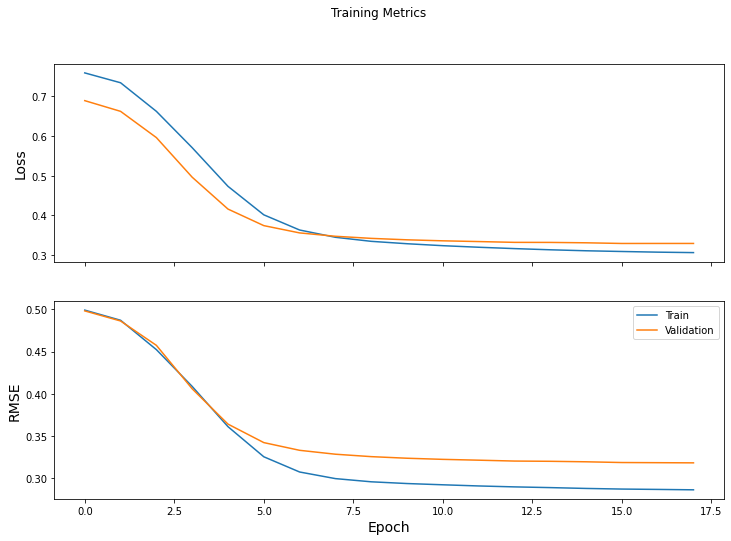

In [ ]:
num_epochs = 18
log_frequency = 1

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
val_loss_avg = tf.keras.metrics.Mean()
val_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

train_step = create_train_step(model, optimizer, loss_fn, epoch_loss_avg, epoch_rmse)
val_step = create_test_step(model, loss_fn, val_loss_avg, val_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

train_loss_results = []
train_rmse_results = []
val_loss_results = []
val_rmse_results = []

timenow = str(datetime.now())

try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)

for epoch in range(num_epochs):
    loss, rmse = train_one_epoch(train_step, train_dataset, lastfm_360_demo, epoch_loss_avg, epoch_rmse, threshold, si=True)
    train_loss_results.append(loss)
    train_rmse_results.append(rmse)

    if (epoch + 1) % log_frequency == 0:
        # Save model
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        loss, rmse = validate_one_epoch(val_step, valid_dataset, lastfm_360_demo, val_loss_avg, val_rmse, threshold, si=True)
        val_loss_results.append(loss)
        val_rmse_results.append(rmse)
        # Plot metrics 
        clear_output(wait=True)
        plot_metrics(train_loss_results, train_rmse_results, val_loss_results, val_rmse_results,  epoch,  log_frequency, timenow)


In [ ]:
probs, loss, rmse = test_one_epoch(test_step, test_dataset, lastfm_360_demo, test_loss_avg, test_rmse, threshold, si=True)
print('Test loss:', loss)
print('Test RMSE:', rmse)

Test loss: 0.14677271
Test RMSE: 0.20905581


In [ ]:
# Prepare a format of predicted ratings to compute metrics
pred_ratings = test.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
_, _, _, _, _  = compute_metrics(test.drop(test[test.rating == 0].index), test['user_email'].unique(), pred_ratings_dict, k)    

Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.2945053302034897
Recall    @ 10: 0.5979900954627343
Ndcg @ 10: 0.6461159424839774
Hit rate: 2.9288010406231777
Arhr: 1.1853903013291958


<a id=cold_start><a>
# Cold start
[Back to content](#content)

Don't split on validation and test because we don't adjust hyperparameters. The 1000 users, that were sampled in the preprocesing.ipynb, are used here as the test set

In [ ]:
ratings = train.append(valid).append(test)
test_indices = ratings['user_email'].isin(test_users)
test_cold = ratings[ratings['user_email'].isin(test_users)]
train_cold = train[~train['user_email'].isin(test_users)]

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_cold)
train_dataset = train_dataset.batch(batch_size).shuffle(train_cold.shape[0], seed=0, reshuffle_each_iteration=True)
test_dataset = tf.data.Dataset.from_tensor_slices(test_cold)
test_dataset = test_dataset.batch(batch_size)

<a id=cold_neumf_wo_si><a>
### NeuMF without user features
[Back to content](#content)

In [ ]:
# Define model, optimizer, and loss function
model = create_neumf_model(num_factors, num_artists, num_users, reg=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

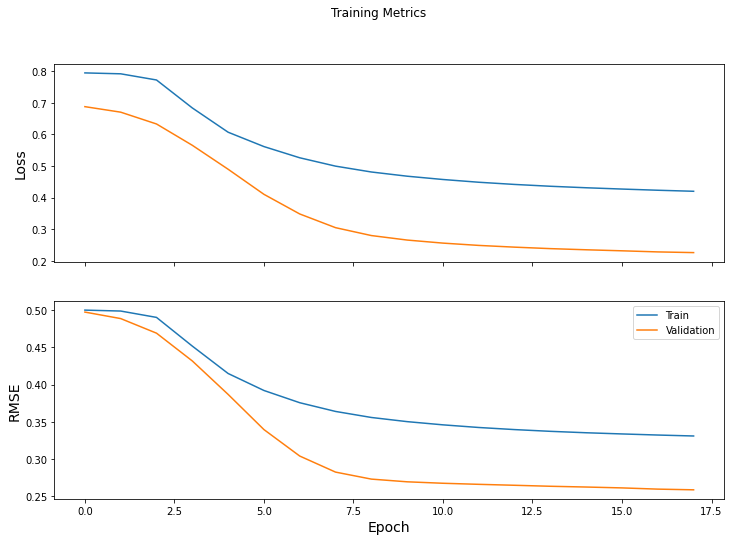

In [ ]:
num_epochs = 18
log_frequency = 1

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

train_step = create_train_step(model, optimizer, loss_fn, epoch_loss_avg, epoch_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

train_loss_results = []
train_rmse_results = []
test_loss_results = []
test_rmse_results = []

timenow = str(datetime.now())

try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)

for epoch in range(num_epochs):
    loss, rmse = train_one_epoch(train_step, train_dataset, lastfm_360_demo, epoch_loss_avg, epoch_rmse, threshold, si=False)
    train_loss_results.append(loss)
    train_rmse_results.append(rmse)

    if (epoch + 1) % log_frequency == 0:
        # Save model
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        loss, rmse = validate_one_epoch(test_step, test_dataset, lastfm_360_demo, test_loss_avg, test_rmse, threshold, si=False)
        test_loss_results.append(loss)
        test_rmse_results.append(rmse)
        # Plot metrics 
        clear_output(wait=True)
        plot_metrics(train_loss_results, train_rmse_results, test_loss_results, test_rmse_results,  epoch, log_frequency, timenow)


In [ ]:
probs, loss, rmse = test_one_epoch(test_step, test_dataset, lastfm_360_demo, test_loss_avg, test_rmse, threshold, si=False)
print('Test loss:', loss)
print('Test RMSE:', rmse)

Test loss: 0.22598414
Test RMSE: 0.2585212


In [ ]:
# Prepare a format of predicted ratings to compute metrics
pred_ratings = test_cold.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
_, _, _, _, _  = compute_metrics(test_cold.drop(test_cold[test_cold.rating == 0].index), test_cold['user_email'].unique(), pred_ratings_dict, k)    

Metrics:

Precision @ 10: 0.8383000000000001 
Recall    @ 10: 0.15231532043364272 
Ndcg @ 10: 0.7728682555208991 
Hit rate: 8.102 
Arhr: 2.4260615079365027


<a id=cold_neumf_w_si><a>
### NeuMF with user features
[Back to content](#content)

In [ ]:
# Define model, optimizer, and loss function
model = create_neumf_model_si(num_factors, num_user_features, num_artists, num_users, reg=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

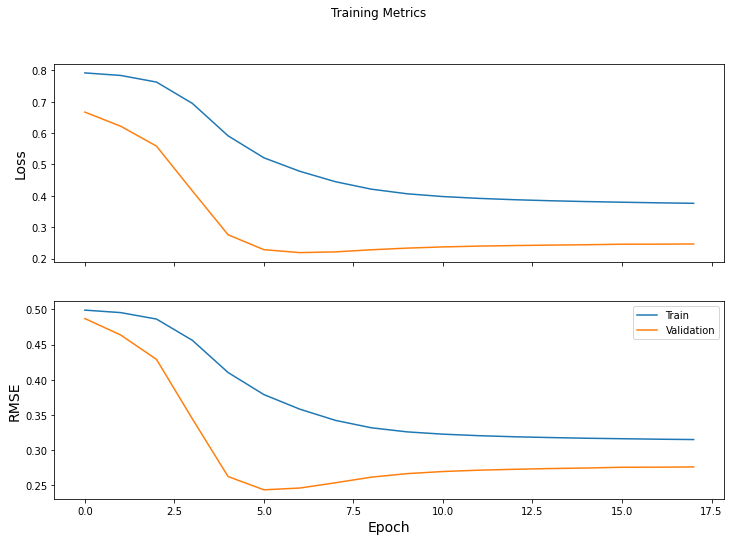

In [ ]:
num_epochs = 18
log_frequency = 1

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

train_step = create_train_step(model, optimizer, loss_fn, epoch_loss_avg, epoch_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

train_loss_results = []
train_rmse_results = []
test_loss_results = []
test_rmse_results = []

timenow = str(datetime.now())

try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)

for epoch in range(num_epochs):
    loss, rmse = train_one_epoch(train_step, train_dataset, lastfm_360_demo, epoch_loss_avg, epoch_rmse, threshold, si=True)
    train_loss_results.append(loss)
    train_rmse_results.append(rmse)

    if (epoch + 1) % log_frequency == 0:
        # Save model
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        loss, rmse = validate_one_epoch(test_step, test_dataset, lastfm_360_demo, test_loss_avg, test_rmse, threshold, si=True)
        test_loss_results.append(loss)
        test_rmse_results.append(rmse)
        # Plot metrics 
        clear_output(wait=True)
        plot_metrics(train_loss_results, train_rmse_results, test_loss_results, test_rmse_results, epoch,  log_frequency, timenow)


In [ ]:
probs, loss, rmse = test_one_epoch(test_step, test_dataset, lastfm_360_demo, test_loss_avg, test_rmse, threshold, si=True)
print('Test loss:', loss)
print('Test RMSE:', rmse)

Test loss: 0.24648945
Test RMSE: 0.2759497


In [ ]:
# Prepare a format of predicted ratings to compute metrics
pred_ratings = test_cold.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
_, _, _, _, _  = compute_metrics(test_cold.drop(test_cold[test_cold.rating == 0].index), test_cold['user_email'].unique(), pred_ratings_dict, k)    

Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.8604
Recall    @ 10: 0.1606464554618612
Ndcg @ 10: 0.7698398633697919
Hit rate: 8.572
Arhr: 2.531304761904752


<a id=cold_neumf_only_si><a>
### NeuMF with only user features
[Back to content](#content)

In [ ]:
# Define model, optimizer, and loss function
model = create_neumf_only_si(num_factors, num_user_features, num_artists, num_users, reg=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

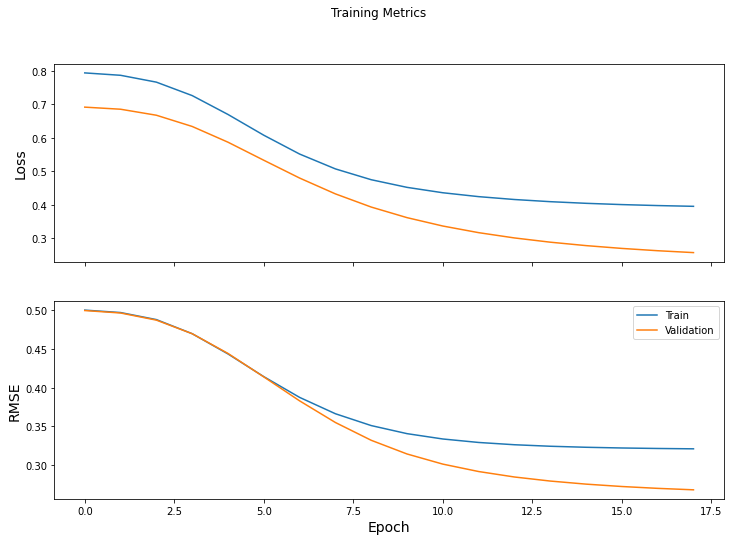

In [ ]:
num_epochs = 18
log_frequency = 1

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

train_step = create_train_step(model, optimizer, loss_fn, epoch_loss_avg, epoch_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

train_loss_results = []
train_rmse_results = []
test_loss_results = []
test_rmse_results = []

timenow = str(datetime.now())

try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)

for epoch in range(num_epochs):
    loss, rmse = train_one_epoch(train_step, train_dataset, lastfm_360_demo, \
                                 epoch_loss_avg, epoch_rmse, threshold, si=False, only_si=True)
    train_loss_results.append(loss)
    train_rmse_results.append(rmse)

    if (epoch + 1) % log_frequency == 0:
        # Save model
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        loss, rmse = validate_one_epoch(test_step, test_dataset, lastfm_360_demo, \
                                        test_loss_avg, test_rmse, threshold, si=False, only_si=True)
        test_loss_results.append(loss)
        test_rmse_results.append(rmse)
        # Plot metrics 
        clear_output(wait=True)
        plot_metrics(train_loss_results, train_rmse_results, test_loss_results, test_rmse_results, epoch,  log_frequency, timenow)


In [ ]:
probs, loss, rmse = test_one_epoch(test_step, test_dataset, lastfm_360_demo, \
                                   test_loss_avg, test_rmse, threshold, si=False, only_si=True)
print('Test loss:', loss)
print('Test RMSE:', rmse)

Test loss: 0.25638708
Test RMSE: 0.2683579


In [ ]:
# Prepare a format of predicted ratings to compute metrics
pred_ratings = test_cold.copy()
pred_ratings['pred'] = probs
pred_ratings_dict = {}
for user, user_df in pred_ratings.groupby('user_email'):
    pred_ratings_dict[user] = np.stack([user_df['artist_id'].to_numpy(), user_df['pred'].to_numpy()])
_, _, _, _, _  = compute_metrics(test_cold.drop(test_cold[test_cold.rating == 0].index), test_cold['user_email'].unique(), pred_ratings_dict, k)    

Computing precision & recall...



Computing normalized discounted cumulative gain...



Computing hit rate...



Computing average reciprocal hit ranking...




Metrics: 

Precision @ 10: 0.8533000000000001
Recall    @ 10: 0.1592852849928114
Ndcg @ 10: 0.7714290897649423
Hit rate: 8.505
Arhr: 2.509356349206342
